---
$$\boxed{\text{\Large{\color{pink}Agentic AI Workshop Day-1}}}$$

$$\text{\textbf{\color{yellow}Theme}: \underline{retrieval before generation, representations before models}}$$
$$\text{\textbf{\color{cyan}Goal}: \underline{to understand that large language models (LLMs) are useless without high quality retrieval}}$$

Today we will explore **how information retrieval systems work from first principles**, using Kannada crime descriptions scraped from the Udupi Police's website. No LLMs today; retrieval comes first.

**Topics**:

1. Kannada text preprocessing
   
2. Classical information retrieval (Inverted Index → Boolean → Phrase)
   
3. Vector Space Model (TF-IDF + Cosine Similarity)
   
4. Pretrained embeddings (semantic retrieval)
   
5. Custom embeddings (small PyTorch model)
   
6. Synthesis & comparison


---


---

Import libraries

---

In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys
import re
import random
import unicodedata
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.9.1
CUDA available: False


---

Mount Google Drive if running in Colab

---

In [2]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2025MAHE/Share/Agentic Workshop/For Students'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = '../Data/'

---

Load Udupi crime data

Expected CSV columns:

- Crime Type
- Location
- Day of Week (label encoded: 0–6)
- Time of Day (0–3)
- Day
- Month
- Year
- Crime Description (Kannada text)

---

In [3]:
## Load Udupi crime data
file = DATA_DIR+'UdupiCrimeData.csv'
df= pd.read_csv(file, header = 0).dropna()

print('Udupi crime dataset')
print('-----------')
print('Number of records = %d'%(df.shape[0]))
print('Number of features = %d\n'%(df.shape[1]))
df.head(5)

Udupi crime dataset
-----------
Number of records = 13457
Number of features = 8



,Crime Type,Location,Day of Week,Time of Day,Day,Month,Year,Crime Description
0,ಮಟ್ಕಾ ಜುಗಾರಿ ಪ್ರಕರಣ,ಗಂಗೊಳ್ಳಿ,6.0,2.0,29.0,2.0,2020.0,ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ...
1,ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ,ಕೊಲ್ಲೂರು,6.0,0.0,29.0,2.0,2020.0,ಪಿರ್ಯಾದಿದಾರರಾಧ ಶ್ರೀಮತಿ ಸಂಧ್ಯಾ ( 59 ವರ್ಷ) ಗಂಡ: ...
2,ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ,ಉಡುಪಿ,6.0,1.0,29.0,2.0,2020.0,"ಪಿರ್ಯಾದಿದಾರರಾದ ಕೆ ರಾಘವೇಂದ್ರ ಸರಳಾಯ(67), ತಂದೆ: ದ..."
3,ಮನುಷ್ಯ ಕಾಣೆ ಪ್ರಕರಣ,ಶಿರ್ವಾ,4.0,0.0,27.0,2.0,2020.0,"ಪಿರ್ಯಾದಿದಾರರಾದ ಕಿಶೋರ್‌ಆಚಾರ್ಯ (31), ತಂದೆ:ಉಪೇಂದ್..."
8,ಅಪಘಾತ ಪ್ರಕರಣ,ಮಲ್ಪೆ,5.0,1.0,21.0,2.0,2020.0,ದಿನಾಂಕ 21/02/2020 ರಂದು 14:00 ಗಂಟೆಗೆ ಪಿರ್ಯಾದಿದಾ...


---

**Kannada Text Preprocessing**:

- Kannada uses complex unicode characters

- Whitespace tokenization is imperfect: tokenization ≠ English tokenization

- Normalization matters

**Hands-on**:

1. Build a minimal tokenizer

2. Inspect word frequency


---

In [4]:
## Function to remove every character that is NOT a Kannada character OR
## whitespace leaving only Kannada letters,
## vowels, and matras, and spaces and line breaks.
def normalize_text(text):
  text = str(text)

  # Normalize unicode representation
  text = unicodedata.normalize("NFKC", text)

  # Unicode range for Kannada: U+0C80 – U+0CFF,
  # Devanagari: U+0900 – U+097F,
  # Tamil: U+0B80 – U+0BFF
  text = re.sub(r"[^\u0C80-\u0CFF\s]", " ", text)

  # Normalize multiple whitespaces
  text = re.sub(r"\s+", " ", text)
  return text.strip()

## Simple whitespace tokenizer for Kannada text

def tokenize(text):
  return normalize_text(text).split()

df["tokens"] = df["Crime Description"].apply(tokenize)
df["tokens"].head()

# Get top 20 common tokens
vocab_counter = Counter()

for tokens in df["tokens"]:
    vocab_counter.update(tokens)

vocab_counter.most_common(20)

[('ಬಗ್ಗೆ', 18347),
 ('ದಿನಾಂಕ', 16582),
 ('ರಂದು', 15890),
 ('ಪೊಲೀಸ್', 15847),
 ('ಕಲಂ', 13857),
 ('ಈ', 13778),
 ('ಗಂಟೆಗೆ', 13616),
 ('ಪ್ರಕರಣ', 13557),
 ('ಕ್ರಮಾಂಕ', 13318),
 ('ವಾಸ', 12746),
 ('ದಾಖಲಾಗಿರುತ್ತದೆ', 12463),
 ('ತಂದೆ', 12292),
 ('ಹಾಗೂ', 12278),
 ('ಉಡುಪಿ', 11620),
 ('ತಾಲೂಕು', 10895),
 ('ಅಪರಾಧ', 10882),
 ('ಠಾಣೆ', 10631),
 ('ಗ್ರಾಮ', 10389),
 ('ಕುಂದಾಪುರ', 10268),
 ('ಪಿರ್ಯಾದಿದಾರರಾದ', 8881)]

---

**Information Retrieval Using Inverted Positional Index**:

- We want a data structure that answers queries like:
  - “which documents contain the word ಕಳ್ಳತನ?”
  - “Where exactly does that word occur in each document?”
  - “Do the words ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ appear consecutively?”

- We build a dictionary: word → { doc_id → [positions] }  (normal index: document → words, inverted index: word → documents)

- This enables: boolean retrieval, phrase queries, and explainable search

- backbone of classical search; everything modern retrieval builds on this idea
  
**Hands on:**

1. Build an inverted positional index for 1,000 crime records and query

---

In [ ]:
inverted_index = defaultdict(lambda: defaultdict(list))

for doc_id, tokens in enumerate(df["tokens"]):
    for pos, word in enumerate(tokens):
        inverted_index[word][doc_id].append(pos)

len(inverted_index)

In [ ]:
## Query a term
term = list(inverted_index.keys())[10]
print(term)
inverted_index[term]

---

**Boolean Retrieval**:

- Query examples using Boolean operators AND, OR, NOT such as "theft AND evening", "assault AND NOT night"

- Exact, fast, and legally explainable — but brittle


**Hands on:**

1. Query "ಕಳ್ಳತನ" and "ಮನೆ"

---

In [ ]:
## Boolean operators
def AND(set1, set2):
    return set1.intersection(set2)

def OR(set1, set2):
    return set1.union(set2)

def NOT(set1, universe):
    return universe - set1

In [ ]:
universe = set(range(len(df)))

term1_docs = set(inverted_index["ಕಳ್ಳತನ"].keys())
term2_docs = set(inverted_index["ಮನೆ"].keys())

AND(term1_docs, term2_docs)

---

**Phrase Query Retrieval**:

- Works by finding documents where words appear consecutively and in an exact order: example "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ ನಡೆದಿದೆ"
  
- Limitations: synonyms, paraphrases, spelling variants

- much stricter than Boolean AND: word order matters

**Hands on:**

1. Query "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"

---

In [ ]:
## Phrase query function
def phrase_query(terms):
  # Look up the first word of the phrase and get all documents
  # that contain it
  candidate_docs = set(inverted_index[terms[0]].keys())

  # For every remaining word: intersect document sets which
  # ensures every candidate document contains all words. This
  # is Boolean retrieval as a pre-filter.
  for term in terms[1:]:
    candidate_docs &= set(inverted_index[term].keys())

  results = []
  # Iterate over all candidate documents
  for doc in candidate_docs:
    # Positions of the first term
    positions = inverted_index[terms[0]][doc]
    # Try matching phrase starting at each position
    for pos in positions:
      # If term-0 at position pos, term-1 at pos+1 etc.,
      # we have the correct order with no gaps. Append doc.
      if all((pos + i) in inverted_index[terms[i]][doc] for i in range(len(terms))):
        results.append(doc)
        break
  return results

In [ ]:
## Phrase query test
terms = ["ಗಂಟೆಗೆ", "ಕುಂದಾಪುರ", "ತಾಲೂಕಿನ"]
phrase_query(terms)

---

**TF-IDF Model**:

- Vector space model--bridge to word embeddings
  
- The first ranking-based retrieval model, acting as a conceptual bridge between symbolic information retrieval and beural embeddings used later in RAG systems

- Answers the question "which document is more relevant"

- Assigns a **real-valued importance score** to every word in every document:$$\text{TF‑IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$ where
    - t = term (word)
    - d = document (crime description)

- TF answers the question "how important is this word *inside this document*?" thus capturing local importance of the word:$$\text{TF}(t, d) = \frac{\text{count of } t \text{ in } d}{\text{total words in } d}$$

- IDF answers the question "how rare is this word across *all* documents?" thus capturing the gloval importance of the word:$$\text{IDF}(t) = \log\left(\frac{N}{1 + \text{DF}(t)}\right)$$where:
  - N = total number of documents
  - DF(t) = number of documents containing term t

- TF‑IDF = Local × Global importance rewarding words that
  - occur frequently in a document, **and**
  - are rare across the dataset


**Hands on:**

1. Compute term frequency (TF) and inverse document frequency (IDF)

2. Build document vectors

3. Rank crime data for query


---

In [ ]:
## Calculate TF-IDF
texts = df['Crime Description'].apply(normalize_text).tolist()

tfidf = TfidfVectorizer(tokenizer = tokenize)
X = tfidf.fit_transform(texts)

In [ ]:
print(X.shape)
print(len(vocab_counter))
print(df.shape[0])

In [ ]:
query = "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
q_vec = tfidf.transform([query])
print(q_vec)

In [ ]:
myarray = np.array([-1, 2, -4, 5, 3, 10, 12, 4, 7])
myarray.argsort()[-5:][::-1]

In [ ]:
## Function for ranking query
def rank_tfidf(query, top_k = 5):
  q_vec = tfidf.transform([query])
  similarities = cosine_similarity(q_vec, X)[0]
  top_doc_ids = similarities.argsort()[-5:][::-1]
  return top_doc_ids, similarities[top_doc_ids]
query = "ಮೊಬೈಲ್ ಫೋನ್ ಕಳವು"
rank_tfidf(query)

In [ ]:
df['Crime Description'].iloc[4014]

---

**Pretrained Embeddings**:

- sentence-transformers/paraphrase-multilingual-MiniLM
  
- IndicSBERT variants

- Black box vs explainability

- Approximate similarity

- Memory cost

**Hands on:**

1. Encode crime data
   
2. Encode queries
   
3. Compare vs TF-IDF results
   
4. Compare top-5 results from TF-IDF vs embeddings
   
5. Which crime data appear only in embedding-based retrieval?


---

In [ ]:
import transformers
import sentence_transformers

print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("sentence-transformers", sentence_transformers.__version__)

In [ ]:
## Load the pre-trained embedding model
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

In [ ]:
## Embed the crime reports
texts = df['Crime Description'].apply(normalize_text).tolist()

X_embeddings = embedder.encode(texts, show_progress_bar = True)

In [ ]:
texts = df['Crime Description'].apply(normalize_text).tolist()
print(texts[0])
print(len(embedder.encode(texts[0])))
tfidf = TfidfVectorizer(tokenizer = tokenize)
X = tfidf.fit_transform(texts)
print(np.sum(X[0].todense()!=0))

In [ ]:
## Function for ranking query
def semantic_search(query, top_k = 5):
  q_vec = embedder.encode([query])
  similarities = cosine_similarity(q_vec, X_embeddings)[0]
  top_doc_ids = similarities.argsort()[-5:][::-1]
  return top_doc_ids, similarities[top_doc_ids]

query = "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
#query = "ಮೊಬೈಲ್ ಫೋನ್ ಕಳವು"
semantic_search(query)

In [ ]:
df['Crime Description'].iloc[13300]

---

**Custom Embeddings**:

- aim not to beat SBERT — learn why it works

- representation learning mindset
  

**Hands on:**

1. Simple PyTorch model (token embedding, mean pooling, contrastive loss / cosine loss, embedding dim: 32 or 64 or 128?)

2. Compare retrieval quality of TF-IDF, pretrained embeddings, and custom embeddings


---

In [5]:
word2idx = {w:i for i, w in enumerate(vocab_counter.keys())}
idx2word = {i:w for w, i in word2idx.items()}

def encode_doc(tokens):
    return [word2idx[t] for t in tokens if t in word2idx]

In [6]:
texts = df['Crime Description'].apply(normalize_text).tolist()
print(texts[0])
encode_doc(texts[0])

ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ ರವರು ದಿನಾಂಕ ರಂದು ಗಂಗೊಳ್ಳಿ ಗ್ರಾಮದ ಖಾರ್ವಿಕೇರಿ ರಸ್ತೆಯ ಸಾರ್ವಜನಿಕ ಸ್ಥಳದಲ್ಲಿ ಪಂಜು ಪೂಜಾರಿ ಎಂಬುವವರು ಮಟ್ಕಾ ಜುಗಾರಿ ನಡೆಸುತ್ತಿದ್ದ ಬಗ್ಗೆ ಸದ್ರಿ ಗ್ರಾಮದ ಬೀಟ್ ಸಿಬ್ಬಂದಿ ನಾಗರಾಜ ಕುಲಾಲ್ ರವರು ನೀಡಿದ ಖಚಿತ ಮಾಹಿತಿಯಂತೆ ಠಾಣಾ ಪಿ ಎಸ್ ಐ ರವರು ಸಿಬ್ಬಂದಿಗಳೊಂದಿಗೆ ಸದ್ರಿ ಸ್ಥಳಕ್ಕೆ ಹೋಗಿ ಗಂಟೆಗೆ ಧಾಳಿ ನಡೆಸಿ ಮಟ್ಕ ಚೀಟಿ ಬರೆಯುತ್ತಿದ್ದ ಆಪಾದಿತ ಪಂಜು ಪೂಜಾರಿ ತಂದೆ ರಾಮ ಪೂಜಾರಿ ಗಂಗೊಳ್ಳಿ ಇವರನ್ನು ವಶಕ್ಕೆ ಪಡೆದು ವಿಚಾರಿಸಿದಲ್ಲಿ ತಾನು ಸ್ವಂತ ಲಾಭಕ್ಕೋಸ್ಕರ ಸಾರ್ವಜನಿಕರಿಂದ ಹಣ ಸಂಗ್ರಹಿಸುತ್ತಿರುವುದಾಗಿ ತಿಳಿಸಿದ್ದು ಮಟ್ಕಾ ಜುಗಾರಿಗೆ ಬಳಸಿದ ಮಟ್ಕ ಚೀಟಿ ಬಾಲ್ ಪೆನ್ನು ಹಾಗೂ ರೂಪಾಯಿ ನಗದು ಹಣವನ್ನು ಸ್ವಾಧೀನ ಪಡಿಸಿಕೊಂಡಿರುವುದಾಗಿದೆ ಈ ಬಗ್ಗೆ ಗಂಗೊಳ್ಳಿ ಪೊಲೀಸ್ ಠಾಣಾ ಅಪರಾಧ ಕ್ರಮಾಂಕ ಕಲಂ ಕರ್ನಾಟಕ ಪೊಲೀಸ್ ಕಾಯ್ದೆಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ


[5379,
 2442,
 417,
 136,
 6663,
 136,
 6663,
 13734,
 136,
 6663,
 3,
 36918,
 36918,
 22596,
 22596,
 13734,
 6663,
 25866,
 417,
 41400,
 417,
 1233,
 295,
 2442,
 417,
 1233,
 36918,
 36918,
 22596,
 22596,
 36918,
 417,
 5379,
 1233,
 417,
 41400,
 2442,
 417,
 417,
 6663,
 8012,
 3656,
 6663,
 417,
 41400,
 33457,
 295,
 2442,
 6663,
 22596,
 1233,
 13734,
 33457,
 13734,
 33457,
 417,
 136,
 36283,
 41400,
 41400,
 417,
 5379,
 2442,
 33457,
 36918,
 417,
 295,
 28196,
 6663,
 8012,
 8012,
 1233,
 1233,
 36283,
 36918,
 36918,
 6663,
 1233,
 417,
 36918,
 417,
 5379,
 1233,
 36283,
 6663,
 36283,
 36283,
 1233,
 295,
 36918,
 417,
 33457,
 2442,
 417,
 41400,
 417,
 295,
 28196,
 1233,
 43052,
 8012,
 5379,
 16602,
 8012,
 3656,
 8012,
 25866,
 13734,
 136,
 6663,
 3,
 417,
 41400,
 417,
 6663,
 36283,
 36283,
 1233,
 36918,
 22596,
 1233,
 36918,
 6663,
 1233,
 417,
 6663,
 22596,
 2442,
 2442,
 16602,
 36918,
 36918,
 36918,
 22596,
 295,
 28196,
 6663,
 5379,
 2442,
 43052,
 

In [7]:
## Simple embedder module
class SimpleEmbedder(nn.Module):
    def __init__(self, vocab_size, dim = 8):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)

    def forward(self, x):
        return self.embed(x).mean(dim = 0)

In [8]:
print(texts[0])
print(encode_doc(texts[0]))
d = torch.tensor(encode_doc(texts[0]))
print(d)
model = SimpleEmbedder(len(word2idx))
model(d)

ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ ರವರು ದಿನಾಂಕ ರಂದು ಗಂಗೊಳ್ಳಿ ಗ್ರಾಮದ ಖಾರ್ವಿಕೇರಿ ರಸ್ತೆಯ ಸಾರ್ವಜನಿಕ ಸ್ಥಳದಲ್ಲಿ ಪಂಜು ಪೂಜಾರಿ ಎಂಬುವವರು ಮಟ್ಕಾ ಜುಗಾರಿ ನಡೆಸುತ್ತಿದ್ದ ಬಗ್ಗೆ ಸದ್ರಿ ಗ್ರಾಮದ ಬೀಟ್ ಸಿಬ್ಬಂದಿ ನಾಗರಾಜ ಕುಲಾಲ್ ರವರು ನೀಡಿದ ಖಚಿತ ಮಾಹಿತಿಯಂತೆ ಠಾಣಾ ಪಿ ಎಸ್ ಐ ರವರು ಸಿಬ್ಬಂದಿಗಳೊಂದಿಗೆ ಸದ್ರಿ ಸ್ಥಳಕ್ಕೆ ಹೋಗಿ ಗಂಟೆಗೆ ಧಾಳಿ ನಡೆಸಿ ಮಟ್ಕ ಚೀಟಿ ಬರೆಯುತ್ತಿದ್ದ ಆಪಾದಿತ ಪಂಜು ಪೂಜಾರಿ ತಂದೆ ರಾಮ ಪೂಜಾರಿ ಗಂಗೊಳ್ಳಿ ಇವರನ್ನು ವಶಕ್ಕೆ ಪಡೆದು ವಿಚಾರಿಸಿದಲ್ಲಿ ತಾನು ಸ್ವಂತ ಲಾಭಕ್ಕೋಸ್ಕರ ಸಾರ್ವಜನಿಕರಿಂದ ಹಣ ಸಂಗ್ರಹಿಸುತ್ತಿರುವುದಾಗಿ ತಿಳಿಸಿದ್ದು ಮಟ್ಕಾ ಜುಗಾರಿಗೆ ಬಳಸಿದ ಮಟ್ಕ ಚೀಟಿ ಬಾಲ್ ಪೆನ್ನು ಹಾಗೂ ರೂಪಾಯಿ ನಗದು ಹಣವನ್ನು ಸ್ವಾಧೀನ ಪಡಿಸಿಕೊಂಡಿರುವುದಾಗಿದೆ ಈ ಬಗ್ಗೆ ಗಂಗೊಳ್ಳಿ ಪೊಲೀಸ್ ಠಾಣಾ ಅಪರಾಧ ಕ್ರಮಾಂಕ ಕಲಂ ಕರ್ನಾಟಕ ಪೊಲೀಸ್ ಕಾಯ್ದೆಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ
[5379, 2442, 417, 136, 6663, 136, 6663, 13734, 136, 6663, 3, 36918, 36918, 22596, 22596, 13734, 6663, 25866, 417, 41400, 417, 1233, 295, 2442, 417, 1233, 36918, 36918, 22596, 22596, 36918, 417, 5379, 1233, 417, 41400, 2442, 417, 417, 6663, 8012, 3656, 6663, 417, 41400, 33457, 295, 2442, 6663, 22596, 1233, 13734, 33457,

tensor([ 0.1201,  0.2136, -0.1536, -0.1956, -0.1828,  0.1636,  0.3393,  0.0168],
       grad_fn=<MeanBackward1>)

In [9]:
## Build a dictionary of crime groups with the
## keys as the crime types and the values as a list
## of crime descriptions corresponding to that type
crime_groups = defaultdict(list)

for _, row in df.iterrows():
    crime_groups[row['Crime Type']].append(row['tokens'])

In [ ]:
## Custom embedding model based on the crime type
# Model
model = SimpleEmbedder(len(word2idx), dim = 8)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-03)
# Loss function
loss_fn = nn.CosineEmbeddingLoss()

In [15]:
## Custom embedding training loop
num_epochs = 1000
epoch_loss = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for crime_type, docs in crime_groups.items():
        # If a crime type has only one crime description
        # then no contribution to training
        if len(docs) < 2:
            continue

        # Pull tokens for a positive pair
        d1_tokens, d2_tokens = random.sample(docs, 2)

        # Pull tokens for a negative pair
        neg_crime = random.choice([ct for ct in crime_groups.keys() if ct != crime_type])
        d3_tokens = random.choice(crime_groups[neg_crime])

        # Encode the positive and negative pairs of documents
        d1 = torch.tensor(encode_doc(d1_tokens))
        d2 = torch.tensor(encode_doc(d2_tokens))
        d3 = torch.tensor(encode_doc(d3_tokens))

        # Forward pass
        e1 = model(d1)
        e2 = model(d2)
        e3 = model(d3)

        # Losses
        pos_label = torch.tensor(1.0)
        neg_label = torch.tensor(-1.0)
        loss_pos = loss_fn(e1, e2, pos_label)
        loss_neg = loss_fn(e1, e3, neg_label)
        loss = loss_pos + loss_neg

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss.append(total_loss)
    print(f'Epoch {epoch} loss: {total_loss:.4f}')


Epoch 0 loss: 104.5545
Epoch 1 loss: 88.7484
Epoch 2 loss: 95.7927
Epoch 3 loss: 92.5525
Epoch 4 loss: 89.9593
Epoch 5 loss: 87.6640
Epoch 6 loss: 84.7314
Epoch 7 loss: 87.2595
Epoch 8 loss: 84.0609
Epoch 9 loss: 84.5729
Epoch 10 loss: 84.5988
Epoch 11 loss: 79.3637
Epoch 12 loss: 75.0323
Epoch 13 loss: 77.7388
Epoch 14 loss: 73.1791
Epoch 15 loss: 70.6456
Epoch 16 loss: 72.4138
Epoch 17 loss: 69.9046
Epoch 18 loss: 70.3506
Epoch 19 loss: 70.5900
Epoch 20 loss: 67.4209
Epoch 21 loss: 66.7018
Epoch 22 loss: 69.9786
Epoch 23 loss: 66.8963
Epoch 24 loss: 58.6199
Epoch 25 loss: 71.0996
Epoch 26 loss: 63.7448
Epoch 27 loss: 66.2627
Epoch 28 loss: 62.4333
Epoch 29 loss: 58.6128
Epoch 30 loss: 61.4741
Epoch 31 loss: 54.6439
Epoch 32 loss: 59.5850
Epoch 33 loss: 57.8347
Epoch 34 loss: 57.8501
Epoch 35 loss: 55.8671
Epoch 36 loss: 57.1482
Epoch 37 loss: 58.3606
Epoch 38 loss: 52.0941
Epoch 39 loss: 58.2780
Epoch 40 loss: 55.4653
Epoch 41 loss: 51.7391
Epoch 42 loss: 52.3674
Epoch 43 loss: 52.35

In [16]:
X_customembeddings = np.empty((df.shape[0], 8))

for i in range(df.shape[0]):
  X_customembeddings[i] = model.forward(torch.tensor(encode_doc(texts[i]))).detach().numpy()

X_customembeddings[0]

array([ 0.18080278, -0.25776786, -0.11408834,  0.29999548, -0.03270262,
       -0.35608533, -0.37588537,  0.24673936])

In [17]:
X_customembeddings = np.empty((df.shape[0], 8))

for i in range(df.shape[0]):
  X_customembeddings[i] = model.forward(torch.tensor(encode_doc(texts[i]))).detach().numpy()

## Function for ranking query
def semantic_search(query, top_k = 5):
  q_vec = model.forward(torch.tensor(encode_doc(query))).detach().numpy().reshape(1, -1)
  similarities = cosine_similarity(q_vec, X_customembeddings)[0]
  top_doc_ids = similarities.argsort()[-5:][::-1]
  return top_doc_ids, similarities[top_doc_ids]

#query = "ಮನೆಯೊಳಗೆ ಕಳ್ಳತನ"
query = "ಮೊಬೈಲ್ ಫೋನ್ ಕಳವು"
semantic_search(query)

(array([ 8210,  9878, 12325,  4171,  9051]),
 array([0.85456135, 0.83041953, 0.81761384, 0.8022209 , 0.80110273]))

In [19]:
df['Crime Description'].iloc[8210]

'ದಿನಾಂಕ 25/05/2017 ರಂದು 11:30 ಗಂಟೆಯಿಂದ 11:45 ಗಂಟೆ ಮದ್ಯಾವಧಿಯಲ್ಲಿ ಮೃತ ಬಾಲಕಿ ಕುಮಾರಿ ಸ್ವಾತಿ (12) ಇವಳು ಮಕ್ಕಳೊಂದಿಗೆ ಆಟವಾಡಲು ಕುಂದಾಪುರ ತಾಲೂಕು ಹೆಂಗವಳ್ಳಿ ಗ್ರಾಮದ ತೊಂಬತ್ತು ಕೊಡಬೈಲು ಎಂಬಲ್ಲಿ ಹೆಂಗವಳ್ಳಿ ಹೊಳೆಗೆ ಹೋದಾಗ ಆಕಸ್ಮೀಕವಾಗಿ ಕಾಲು ಜಾರಿ ಹೊಳೆಯ ಮದ್ಯದಲ್ಲಿ ಕುಡಿಯುವ ನೀರಿಗಾಗಿ ತೋಡಿದ ಹೊಂಡಕ್ಕೆ ಬಿದ್ದು ಮೃತಪಟ್ಟಿರುತ್ತಾಳೆ, ಎಂಬುದಾಗಿ ಬೋಜ ಮಡಿವಾಳ (32) ತಂದೆ: ತಿಮ್ಮ ಮಡಿವಾಳ ವಾಸ::ತೊಂಬತ್ತು ಹೆಂಗವಳ್ಳಿ ಗ್ರಾಮ ಕುಂದಾಪುರ ಇವರು ನೀಡಿದ ದೂರಿನಂತೆ ಶಂಕರನಾರಾಯಣ ಪೊಲೀಸ್\u200c ಠಾಣಾ ಯು, ಡಿ, ಆರ್ ಕ್ರಮಾಂಕ 18/2017 ಕಲಂ:174 ಸಿ.ಆರ್.ಪಿ.ಸಿಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ.'

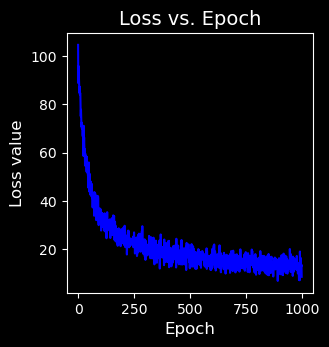

In [20]:
## Plot loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(epoch_loss, 'b')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.set_title('Loss vs. Epoch', fontsize = 14);

**Comparing Information Retrieval Techniques**:

| Method         | Explainable | Semantic | Memory | Speed  |
| -------------- | ----------- | -------- | ------ | ------ |
| Boolean        | ?           | ?        | ?    | ?   |
| TF-IDF         | ?          | ?       | ? | ?   |
| Pretrained Emb | ?           | ?        | ?   | ? |
| Custom Emb     | ?          | ?       | ?    | ?   |

**How Day-1 Concepts Lead to Day-2 Use?**

| Day-1 Concept     | Day-2 Use                      |
| ----------------- | ------------------------------ |
| Inverted index    | Keyword filtering before RAG   |
| TF-IDF            | Sparse retriever in hybrid RAG |
| Embeddings        | Vector store                   |
| Custom embeddings | Memory-efficient RAG           |
| Dimensionality    | QLoRA intuition                |
